In [1]:
from math import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from scipy.interpolate import lagrange
from scipy.optimize import curve_fit
import re
from scipy.stats import boxcox, ttest_ind
from scipy.stats import rv_histogram
import scipy.stats as stats
from scipy.special import inv_boxcox
import statsmodels as sm
import sklearn as sk
from sklearn.preprocessing import power_transform
from multiprocessing import Pool
from mpl_toolkits.basemap import Basemap as Basemap
import mplleaflet

#network analysis packages
import networkx as nx
import community
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities
import warnings
from matplotlib.collections import LineCollection
import geopy.distance

#web-scraping
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents

from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
import difflib #for finding closest word match
import os

# 1. Reading in Data, Cleaning and Processing

In [256]:
raw_flow_data = pd.read_excel('commuting_flows.xlsx', header = 6, converters={'State FIPS Code': str,
                                                                              'County FIPS Code': str,
                                                                              'State FIPS Code.1': str,
                                                                              'County FIPS Code.1': str})


In [257]:
flow_df = raw_flow_data.dropna()
ca_flows = flow_df[(flow_df['State Name'] == 'California') | (flow_df['State Name.1'] == 'California')]

In [258]:
ca_flows = ca_flows[['State Name', 'County Name', 'State Name.1', 'County Name.1', 
                     'Workers in Commuting Flow', 
                     ' Margin of Error']].rename(columns = {'County Name': 'Origin', 
                                                            'County Name.1': 'Destination',
                                                            'Workers in Commuting Flow': 'Flow',
                                                            ' Margin of Error': 'Error',
                                                            'State Name': 'Origin State',
                                                            'State Name.1': 'Destination State'})
                                                                                                              

In [253]:
ca_flows

,Origin State,Origin,Destination State,Destination,Flow,Error
60,Alabama,Baldwin County,California,Los Angeles County,10.0,17.0
61,Alabama,Baldwin County,California,San Bernardino County,23.0,38.0
62,Alabama,Baldwin County,California,San Diego County,81.0,78.0
168,Alabama,Bibb County,California,Los Angeles County,13.0,19.0
340,Alabama,Chambers County,California,Tuolumne County,9.0,15.0
...,...,...,...,...,...,...
137354,Wyoming,Sweetwater County,California,San Bernardino County,18.0,29.0
137402,Wyoming,Uinta County,California,Orange County,49.0,44.0
137676,Puerto Rico,Bayamón Municipio,California,San Mateo County,13.0,19.0
137870,Puerto Rico,Carolina Municipio,California,Los Angeles County,18.0,20.0


In [42]:
# get county centroid longitude and latitude
wikiurl = 'https://en.wikipedia.org/wiki/User:Michael_J/County_table'
table_class = "wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

200


In [44]:
soup = BeautifulSoup(response.text, 'html.parser')
county_loc_table = soup.find('table',{'class':"wikitable"})

In [298]:
county_df = pd.read_html(str(county_loc_table))
# convert list to dataframe
county_df = pd.DataFrame(county_df[0])

In [299]:
state_code_mapping = pd.read_csv('state_codes.csv')[['Code', 'State']].set_index('Code').to_dict()['State']

In [300]:
county_df['State'] = county_df['State'].map(state_code_mapping)

In [303]:
for ii in county_df.index:
    county_df.loc[ii, 'County [2]'] = county_df.loc[ii, 'County [2]'] + ' County'
    county_df.loc[ii, 'Latitude'] = re.search("[\d.]+", county_df['Latitude'][ii]).group(0)
    county_df.loc[ii, 'Longitude'] = re.search("[\d.]+", county_df['Longitude'][ii]).group(0)
    
county_df = county_df.rename(columns = {'County [2]': 'County'})

In [306]:
county_df_loc = county_df[['State', 'County', 'Latitude', 'Longitude']]

In [259]:
f = {'Flow':['sum'], 'Error':['mean']}

ca_flows = ca_flows.groupby(['Origin', 'Destination', 'Origin State', 'Destination State']).agg(f).reset_index()

In [260]:
ca_flows

,Origin,Destination,Origin State,Destination State,Flow,Error
,,,,,sum,mean
0,Ada County,Alameda County,Idaho,California,169.0,157.0
1,Ada County,Contra Costa County,Idaho,California,16.0,26.0
2,Ada County,Los Angeles County,Idaho,California,48.0,48.0
3,Ada County,Orange County,Idaho,California,21.0,36.0
4,Ada County,Riverside County,Idaho,California,10.0,20.0
...,...,...,...,...,...,...
6381,Yuma County,San Bernardino County,Arizona,California,54.0,49.0
6382,Yuma County,San Diego County,Arizona,California,96.0,86.0
6383,Yuma County,Sonoma County,Arizona,California,14.0,18.0


In [261]:
ca_flows_df = pd.DataFrame()
ca_flows_df['Origin'] = ca_flows[ca_flows.columns[0]]
ca_flows_df['Destination'] = ca_flows[ca_flows.columns[1]]
ca_flows_df['Origin State'] = ca_flows[ca_flows.columns[2]]
ca_flows_df['Destination State'] = ca_flows[ca_flows.columns[3]]
ca_flows_df['Flow'] = ca_flows[ca_flows.columns[4]]
ca_flows_df['Error'] = ca_flows[ca_flows.columns[5]]

In [320]:
ca_flows_loc = ca_flows_df.merge(county_df_loc, how = 'left', left_on = ['Origin', 'Origin State'], right_on = ['County', 'State']).drop_duplicates()

ca_flows_loc = ca_flows_loc.drop(['State', 'County'], axis = 1).rename(columns = {'Latitude': 'Origin Lat',
                                                                                  'Longitude': 'Origin Lon'})


In [321]:
ca_flows_loc = ca_flows_loc.merge(county_df_loc, how = 'left', left_on = ['Destination', 'Destination State'], right_on = ['County', 'State']).drop_duplicates()

ca_flows_loc = ca_flows_loc.drop(['State', 'County'], axis = 1).rename(columns = {'Latitude': 'Dest Lat',
                                                                                  'Longitude': 'Dest Lon'})

In [322]:
ca_flows_loc

,Origin,Destination,Origin State,Destination State,Flow,Error,Origin Lat,Origin Lon,Dest Lat,Dest Lon
0,Ada County,Alameda County,Idaho,California,169.0,157.0,43.447861,116.244456,37.648081,121.913304
1,Ada County,Contra Costa County,Idaho,California,16.0,26.0,43.447861,116.244456,37.919479,121.951543
2,Ada County,Los Angeles County,Idaho,California,48.0,48.0,43.447861,116.244456,34.196398,118.261862
3,Ada County,Orange County,Idaho,California,21.0,36.0,43.447861,116.244456,33.675687,117.777207
4,Ada County,Riverside County,Idaho,California,10.0,20.0,43.447861,116.244456,33.729828,116.002239
...,...,...,...,...,...,...,...,...,...,...
6381,Yuma County,San Bernardino County,Arizona,California,54.0,49.0,32.773942,113.910905,34.857220,116.181197
6382,Yuma County,San Diego County,Arizona,California,96.0,86.0,32.773942,113.910905,33.023604,116.776117
6383,Yuma County,Sonoma County,Arizona,California,14.0,18.0,32.773942,113.910905,38.532574,122.945194
6384,Yuma County,Tuolumne County,Arizona,California,5.0,7.0,32.773942,113.910905,38.021451,119.964708


In [323]:
ca_flows_loc.to_csv('Save Points/ca_flows_df.csv', index = False)

# 2. Creating the Network of Flows

In [324]:
ca_flows_loc = pd.read_csv('Save Points/ca_flows_df.csv')

In [335]:
ca_flows_loc = ca_flows_loc.dropna()

In [336]:
#create location dictionary for latitude and longitude of airports
lat_lon_dict = {}
for kk in ca_flows_loc.index.unique():
    lat_lon_dict[ca_flows_loc.loc[kk]['Origin']] = (ca_flows_loc.loc[kk]['Origin Lon'], ca_flows_loc.loc[kk]['Origin Lat'])
    lat_lon_dict[ca_flows_loc.loc[kk]['Destination']] = (ca_flows_loc.loc[kk]['Dest Lon'], ca_flows_loc.loc[kk]['Dest Lat'])

In [339]:
#create network 
ca_flow_nx = nx.Graph()
for aa in ca_flows_loc.index:
    ca_flow_nx.add_edge(ca_flows_loc.loc[aa]['Origin'], 
                        ca_flows_loc.loc[aa]['Destination'], 
                        weight = ca_flows_loc.loc[aa]['Flow'])

In [405]:
#basic network analysis:
print('nodes:', len(ca_flow_nx.nodes()))
print('edges:', len(ca_flow_nx.edges()))
print('average degree:', sum(list(dict(ca_flow_nx.degree).values())) / len(ca_flow_nx.nodes()))
print('average clustering:', nx.average_clustering(ca_flow_nx, weight = 'weight'))
print('average shortest path: ', nx.average_shortest_path_length(ca_flow_nx))

nodes: 850
edges: 4356
average degree: 10.249411764705883
average clustering: 8.086333227081506e-06
average shortest path:  2.4390771149449177


In [435]:
emp_avg_deg = sum(list(dict(ca_flow_nx.degree).values())) / len(ca_flow_nx.nodes())

C_p = nx.average_shortest_path_length(ca_flow_nx)
C0 = nx.average_clustering(nx.watts_strogatz_graph(len(ca_flow_nx.nodes()), round(emp_avg_deg), p = 0))
p = 1 - (C_p / C0)**(1/3)

#small world network
small_world_nx = nx.watts_strogatz_graph(len(ca_flow_nx.nodes()), round(emp_avg_deg), p)
print('sw clustering', nx.average_clustering(small_world_nx, weight = 'weight'))
print('sw average shortest path: ', nx.average_shortest_path_length(small_world_nx))

sw clustering 0.6666666666666698
sw average shortest path:  42.95053003533569


In [433]:
k_min = min(list(dict(ca_flow_nx.degree()).values()))

In [434]:
#barabasi 
scale_free_nx = nx.barabasi_albert_graph(len(ca_flow_nx.nodes()), k_min)
print('sf clustering', nx.average_clustering(scale_free_nx, weight = 'weight'))
print('sf average shortest path: ', nx.average_shortest_path_length(scale_free_nx))
print('nodes:', len(scale_free_nx.nodes()))
print('edges:', len(scale_free_nx.edges()))

sf clustering 0.0
sf average shortest path:  5.947572923162197
nodes: 850
edges: 849


In [380]:
degrees = dict(ca_flow_nx.degree(weight = 'weight'))
degrees = list(degrees.values())

In [382]:
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

degrees = remove_values_from_list(degrees,0)

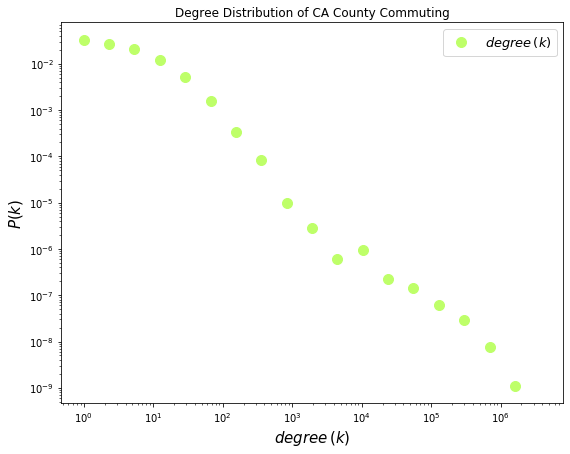

In [392]:
fig, ax = plt.subplots()
fig.set_size_inches((9, 7))

n_bins = 20

#n, bins = np.histogram(out_d, bins = range(min(out_d), max(out_d)+1, 2), normed="True") 
logBins = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)),num = n_bins)
logBinDensity, binedges = np.histogram(degrees, bins = logBins, density = True)

ax.loglog(logBins[:-1], logBinDensity,'o', markersize = 10, color = '#beff69', label = r'$degree\,(k)$')
ax.legend(fontsize = 13)

ax.set_xlabel('$degree\,(k)$',fontsize=15);
ax.set_ylabel('$P(k)$',fontsize=15);
ax.set_title('Degree Distribution of CA County Commuting');
plt.savefig("deg_dist_ca", dpi = 300, bbox_inches = 'tight')

In [440]:
distances = []
for dd in ca_flows_loc.index:
    o_lat = ca_flows_loc.loc[dd, 'Origin Lat']; o_lon = ca_flows_loc.loc[dd, 'Origin Lon']; 
    d_lat = ca_flows_loc.loc[dd, 'Dest Lat']; d_lon = ca_flows_loc.loc[dd, 'Dest Lon']; 
    temp = geopy.distance.distance((o_lat, o_lon), (d_lat, d_lon)).miles
    distances.append(temp)

In [442]:
ca_flows_loc['Distance'] = distances

In [444]:
ef_pmt = 0.2317

ca_flows_loc['CO2e (kg)'] = ca_flows_loc['Flow'] * ca_flows_loc['Distance'] * ef_pmt

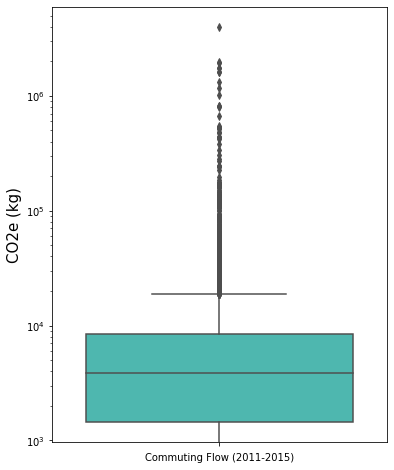

In [479]:
fig, ax = plt.subplots(figsize = (6,8))
sns.boxplot(y = 'CO2e (kg)', data = ca_flows_loc, color = '#3cc9be');
ax.set_yscale('log')
ax.set_ylabel('CO2e (kg)', fontsize = 15);
ax.set_xlabel('Commuting Flow (2011-2015)');
plt.savefig("emission_boxplot", dpi = 300, bbox_inches = 'tight')
plt.show()

In [491]:
print('total: ',ca_flows_loc['CO2e (kg)'].sum())
print('mean: ',ca_flows_loc['CO2e (kg)'].mean())
print('median: ',ca_flows_loc['CO2e (kg)'].median())

total:  76282146.8923983
mean:  12786.145975930014
median:  3865.3142622343257


In [500]:
temp_df = ca_flows_loc[ca_flows_loc['Origin'] != ca_flows_loc['Destination']]
intra_state = (temp_df['Origin State'] == temp_df['Destination State']) * 1
temp_df['Intra State'] = intra_state

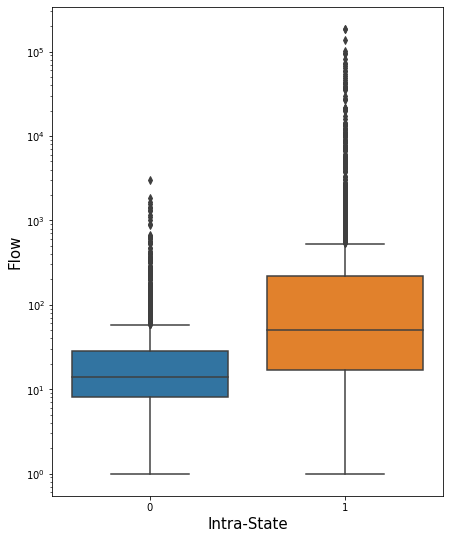

In [513]:
fig, ax = plt.subplots(figsize = (7,9))

sns.boxplot(x = 'Intra State', y = 'Flow', data = temp_df)
ax.set_yscale('log')
ax.set_ylabel('Flow', fontsize = 15);
ax.set_xlabel('Intra-State', fontsize = 15)
plt.savefig("intra_state_boxplot", dpi = 300, bbox_inches = 'tight')
plt.show()

In [514]:
ca_flows_loc

,Origin,Destination,Origin State,Destination State,Flow,Error,Origin Lat,Origin Lon,Dest Lat,Dest Lon,Distance,CO2e (kg)
0,Ada County,Alameda County,Idaho,California,169.0,157.0,43.447861,116.244456,37.648081,121.913304,498.903794,19535.725528
1,Ada County,Contra Costa County,Idaho,California,16.0,26.0,43.447861,116.244456,37.919479,121.951543,484.904936,1797.639579
2,Ada County,Los Angeles County,Idaho,California,48.0,48.0,43.447861,116.244456,34.196398,118.261862,647.325972,7199.300527
3,Ada County,Orange County,Idaho,California,21.0,36.0,43.447861,116.244456,33.675687,117.777207,679.111623,3304.353426
4,Ada County,Riverside County,Idaho,California,10.0,20.0,43.447861,116.244456,33.729828,116.002239,670.451385,1553.435859
...,...,...,...,...,...,...,...,...,...,...,...,...
6381,Yuma County,San Bernardino County,Arizona,California,54.0,49.0,32.773942,113.910905,34.857220,116.181197,194.086290,2428.368839
6382,Yuma County,San Diego County,Arizona,California,96.0,86.0,32.773942,113.910905,33.023604,116.776117,167.450884,3724.643495
6383,Yuma County,Sonoma County,Arizona,California,14.0,18.0,32.773942,113.910905,38.532574,122.945194,644.444937,2090.450487
6384,Yuma County,Tuolumne County,Arizona,California,5.0,7.0,32.773942,113.910905,38.021451,119.964708,497.399874,576.237754


In [515]:
import contextily as ctx
from pyproj import Transformer

TRAN_4326_TO_3857 = Transformer.from_crs("EPSG:4326", "EPSG:3857")

def transform_coordinates(loc_dict):
    transformed = {}
    for airport in loc_dict:
        transformed[airport] = TRAN_4326_TO_3857.transform(loc_dict[airport][1], loc_dict[airport][0])
    return transformed

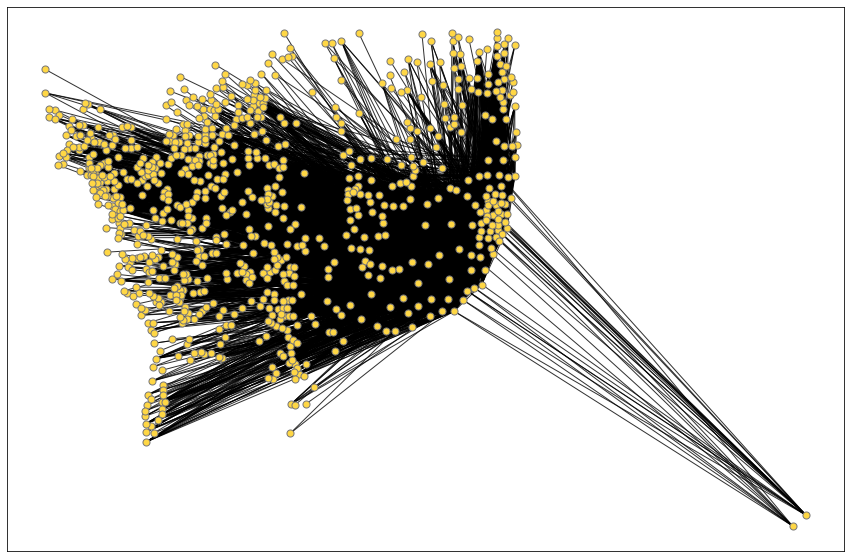

In [524]:
plt.figure(figsize = (15, 10))
edges = nx.draw_networkx_edges(ca_flow_nx, pos = lat_lon_dict, alpha = 0.8, 
                                   style = 'solid', connectionstyle = "arc3,rad=0.2")
nodes = nx.draw_networkx_nodes(ca_flow_nx, pos = lat_lon_dict, node_size = 50, node_color = '#ffd745', 
                                   alpha = 1, edgecolors = '#787777')
west, south, east, north = (-125.59624, 31.95, -108.93022, 45.55)
ca_region_img, ca_extent = ctx.bounds2img(west, south, east, north, ll = True,
                                           source = ctx.providers.CartoDB.VoyagerNoLabels)

In [522]:
lat_lon_dict.values()

dict_values([(116.244456, 43.447860999999996), (121.91330400000001, 37.648081), (121.95154299999999, 37.919478999999995), (118.26186200000001, 34.196397999999995), (117.777207, 33.675686999999996), (116.00223899999999, 33.729828000000005), (123.032229, 37.727239000000004), (122.37154199999999, 37.414664), (121.69062199999999, 37.220777000000005), (104.331872, 39.874325), (121.002656, 37.562384), (81.63387, 33.549316999999995), (121.340441, 38.450010999999996), (82.357221, 29.67574), (79.399935, 36.041973999999996), (105.721883, 41.665514), (79.98092, 40.468920000000004), (77.100703, 38.878337), (84.838188, 34.240918), (119.51686399999998, 46.228072), (106.66906499999999, 35.054002000000004), (113.95528999999999, 43.394482), (116.59693999999999, 48.312512), (105.39838200000001, 40.094826), (75.830291, 42.161977), (80.476658, 26.19352), (111.350571, 47.316443), (94.933302, 41.333824), (115.013819, 36.214236), (87.645455, 41.894294), (96.778424, 32.766987), (89.417852, 43.067468), (86.784